# Empirical Analysis
In this python notebook we are going to:
1. Get the Data from the Statsbomb Open Data API and save it with timestamp
2. Run an empirical analysis on the data
3. Transform the data if needed

#### 1. Get the data from the Statsbomb Open Data API and saving it

In [1]:
# Import all the libraries used to get the data
from statsbombpy import sb
import pandas as pd
import os
from tqdm import tqdm
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
# We don't have an API-key, so we will ignore that exact warning
import warnings
warnings.filterwarnings('ignore', category=sb.api_client.NoAuthWarning)

In [2]:
# Since we want as much data as possible, we will first query for all available match_ids
all_competition_season_ids = sb.competitions()[['competition_id', 'season_id']].apply(lambda row: (row['competition_id'], row['season_id']), axis='columns')
# For every competition and each season download the match meta-data
if not os.path.exists('name_to_id_mapping.csv'): 
    name_to_competition_id_mapping = pd.DataFrame({ 'competition_name': [],
                                                    'season_name': [],
                                                    'competition_id': [],
                                                    'season_id': [],
                                                    'time_downloaded': []})
else:
    name_to_competition_id_mapping = pd.read_csv('name_to_id_mapping.csv')
if not os.path.exists('statsbomb_data'):
    os.mkdir('statsbomb_data')
# We only need to look at the subset of the columns for each match
for competition_id, season_id in tqdm(all_competition_season_ids):
    directory_name = f'statsbomb_data/{competition_id}_{season_id}'
    if os.path.exists(directory_name):
        continue
    os.mkdir(directory_name)
    matches = sb.matches(competition_id=competition_id, season_id=season_id)
    # This makes it easier for humans to look at the data later
    # Download the events for each match
    for match_id in tqdm(sb.matches(competition_id=competition_id, season_id=season_id)['match_id'].unique()):
        # If the file already exists, we skip it
        if os.path.exists(f'{directory_name}/{match_id}.pkl'):
            continue
        sb.events(match_id=match_id, split=True)['shots'].to_pickle(f'{directory_name}/{match_id}.pkl')
    name_to_competition_id_mapping.loc[len(name_to_competition_id_mapping)] = [matches['competition'][0], matches['season'][0], competition_id,season_id, str(datetime.now())]
    name_to_competition_id_mapping.to_csv('name_to_id_mapping.csv')

100%|██████████| 71/71 [00:00<00:00, 40738.11it/s]


#### 2. Running empirical analysis
To run the empirical analysis on the data we first load all the data into memory as a single dataframe.

In [3]:
# shots_df is a big dataframe with all the shots from all the matches downloaded
shots_df = pd.concat([pd.concat([pd.read_pickle(os.path.join(root, file)) for file in files]) for root, _, files in list(os.walk('statsbomb_data'))[1:]])
# Print some meta-data of the dataframe
print(f'Amount of shots: {len(shots_df)}')
print(f'Amount of unique matches: {len(shots_df["match_id"].unique())}')
print(f'Available columns:\n{shots_df.columns}')
shots_df.head()

Amount of shots: 84065
Amount of unique matches: 3316
Available columns:
Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type',
       'possession', 'possession_team', 'play_pattern', 'team', 'player',
       'position', 'location', 'duration', 'related_events', 'match_id',
       'shot_statsbomb_xg', 'shot_end_location', 'shot_key_pass_id',
       'shot_outcome', 'shot_first_time', 'shot_type', 'shot_body_part',
       'shot_technique', 'shot_freeze_frame', 'possession_team_id', 'team_id',
       'player_id', 'under_pressure', 'shot_aerial_won', 'shot_one_on_one',
       'shot_redirect', 'out', 'shot_open_goal', 'shot_deflected',
       'off_camera', 'shot_follows_dribble', 'shot_saved_to_post',
       'shot_saved_off_target', 'shot_kick_off'],
      dtype='object')


,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,shot_one_on_one,shot_redirect,out,shot_open_goal,shot_deflected,off_camera,shot_follows_dribble,shot_saved_to_post,shot_saved_off_target,shot_kick_off
0,08eb8fb6-02d1-4124-92e7-2fed285e9b81,40,1,00:00:51.155,0,51,Shot,4,AC Milan,From Free Kick,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0afba362-b890-445f-a2e8-a880fdf6caf1,126,1,00:03:48.106,3,48,Shot,11,Liverpool,From Corner,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,f1f292c0-5590-4108-b3bf-36d4f4aaf756,133,1,00:03:57.139,3,57,Shot,12,Liverpool,Regular Play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ef380ac5-5548-4102-85dc-03f6e68a72e2,334,1,00:09:34.205,9,34,Shot,24,AC Milan,From Throw In,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,64cc7e5d-31f8-4ec0-9df6-ebe9b1d2880b,477,1,00:13:36.820,13,36,Shot,36,AC Milan,From Corner,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Empirical Probability Density')

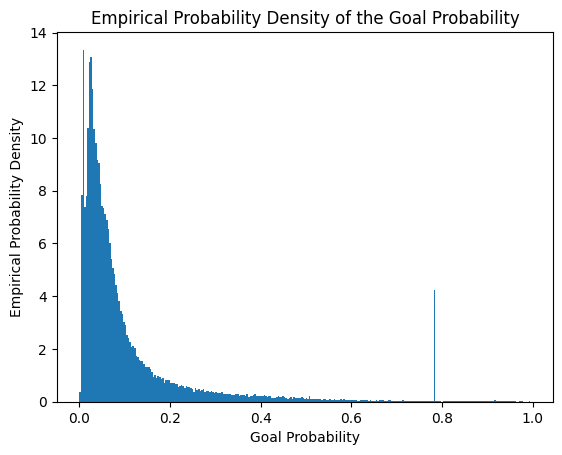

In [4]:
# Plot the distribution of the xG values as a probability density
plt.hist(shots_df['shot_statsbomb_xg'], bins=int(np.sqrt(len(shots_df))), density=True)
plt.title('Empirical Probability Density of the Goal Probability')
plt.xlabel('Goal Probability')
plt.ylabel('Empirical Probability Density')

### Possession xG
When looking at the shots on a match basis, we observe that for a single possession ID there might exist multiple shots. To fit this into the notion for an xG being the probability that a goal opportunity results in a goal we have to reduce the probabilities which belong to one possession to one single probability.

For a sequence of $n$ xG values $\text{xG}_1, \text{xG}_2, ..., \text{xG}_n$ which belong to a single possession we calculate the Possession xG as

$ \text{Possession xG} = \text{xG}_1 + (1 - \text{xG}_1) \cdot \text{xG}_2 +\ _{\cdots} + (1 - \text{xG}_1) \cdot (1 - \text{xG}_2) \cdot\ _{\cdots} \cdot (1 - \text{xG}_{n-1}) \cdot \text{xG}_n $ .

So with every shot that is taken in a possession, the Possession xG increases by the probability that the previous shots did not result in a goal and the following shot will result in a goal. The shots on goal are assumed to be stochastically independent.

In [5]:
# To reduce the xG values to Possession xG, we frist have to group the entries of our dataframe by match id and possession id
# Create a possession id, a possession ID is a triple of (match id, possession number, team id)
shots_df['possession_id'] = shots_df.apply(lambda row: (row['match_id'], row['possession'], row['team_id']), axis=1)
# create a function which takes in the dataframe for each group and outputs the Possession xG
def get_possession_xg(df):
    df.sort_values('timestamp', inplace=True)
    possession_xg = 0
    for i, xg in enumerate(df['shot_statsbomb_xg']):
        previous_shots = df['shot_statsbomb_xg'].iloc[:i].apply(lambda x: 1 - x).product(axis='index')
        possession_xg += xg*previous_shots
    return possession_xg
tqdm.pandas()
possession_xgs = shots_df.groupby('possession_id').progress_apply(get_possession_xg)

100%|██████████| 77423/77423 [01:05<00:00, 1179.50it/s]


Amount of Possession xG values: 77423


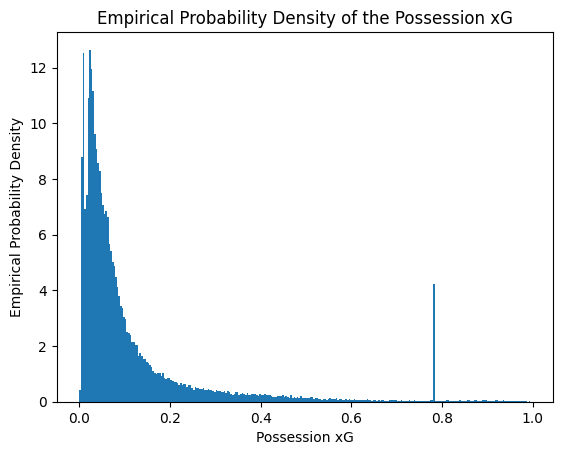

In [6]:
# Plot the distribution as a probability density function for the Possession xG
plt.clf()
plt.hist(possession_xgs, bins=int(np.sqrt(len(possession_xgs))), density=True)
plt.title('Empirical Probability Density of the Possession xG')
plt.xlabel('Possession xG')
plt.ylabel('Empirical Probability Density')
print(f'Amount of Possession xG values: {len(possession_xgs)}')

In [7]:
# Save the Possession xG values as a dataframe including the relevant ID's
possession_xg_df = {'match_id': [], 'possession': [], 'team_id': []}
for possession_id in possession_xgs.index:
    match_id, possession, team_id = possession_id
    possession_xg_df['match_id'].append(match_id)
    possession_xg_df['possession'].append(possession)
    possession_xg_df['team_id'].append(team_id)
possession_xg_df = pd.DataFrame(possession_xg_df)
possession_xg_df['possession_xg'] = possession_xgs.values
possession_xg_df.to_pickle('possession_xGs.pkl')

100%|██████████| 3316/3316 [00:02<00:00, 1454.72it/s]


Total amount of matches in which a team has a Possession xG: 6625


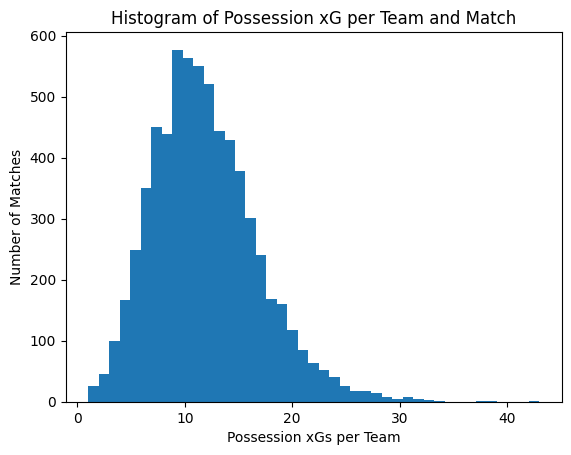

In [8]:
# Let's analyze now on a match level how many Possession xG's each team has
team_shot_count = possession_xg_df.groupby('match_id').progress_apply(lambda df: list(df.groupby('team_id')['possession_xg'].count())).sum()
plt.clf()
plt.hist(team_shot_count, bins=max(team_shot_count))
plt.title('Histogram of Possession xG per Team and Match')
plt.xlabel('Possession xGs per Team')
plt.ylabel('Number of Matches')
print(f'Total amount of matches in which a team has a Possession xG: {len(team_shot_count)}')

  0%|          | 0/3316 [00:00<?, ?it/s]

100%|██████████| 3316/3316 [00:02<00:00, 1533.14it/s]


Total amount of matches in which a team has a team has at least one shot: 6625


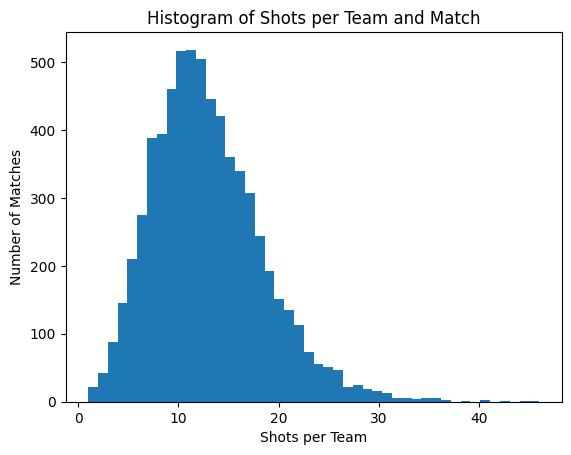

In [9]:
# It would also be interesting to see how the histogram for amount of shots per team and match looks
shots_per_team_and_match = shots_df[['match_id', 'team_id']].groupby('match_id').progress_apply(lambda df: list(df.groupby('team_id')['team_id'].count())).sum()
plt.clf()
plt.hist(shots_per_team_and_match, bins=max(shots_per_team_and_match))
plt.title('Histogram of Shots per Team and Match')
plt.xlabel('Shots per Team')
plt.ylabel('Number of Matches')
print(f'Total amount of matches in which a team has a team has at least one shot: {len(shots_per_team_and_match)}')